In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time as pytime
from pathlib import Path

from dolfin import *
from multirat import *
# from multirat.parameters import PARAMS
import multirat.base.projectors as projectors
import multirat.base

In [7]:
MESH_DIR = Path("../mesh").resolve()
RESULTS_DIR = Path("../results").resolve()

## Homogeneous 

In [8]:
# Init arguments
dt = 60.
T = 3600.
res = 32
time = TimeKeeper(dt, T)
domain = hdf2fenics(f"{MESH_DIR}/mesh{res}.h5", pack=True)
V = FunctionSpace(domain.mesh, "CG", 1)

# Define initial Condition
u0 = HomogeneousDirichletProjector().project(
        gaussian_expression(center=PARAMS["injection_center"], std=PARAMS["injection_spread"], degree=1), V
)
projectors.rescale_function(u0, 1.)
problem = HomogeneousProblem(domain, time, u0, V)

results_path = f"{RESULTS_DIR}/testpath"
computer_homogeneous = BaseComputer({"amounts_total": lambda u: assemble(u * dx)})
solve_diffusion_problem(problem, results_path, computer_homogeneous)
time.reset()

# Perform plotting
plt.figure()
plt.plot(computer_homogeneous["amounts_total"])
plt.show()

NameError: name 'TimeKeeper' is not defined

## Tracer Conservation

In [3]:
# Initiate problem, computers, and solve the problem
problem = TracerConservationProblem(domain, time, u0, V)
computer_conservation = BaseComputer({"amounts_total": lambda u: assemble(u * dx)})
 
# 
time.reset()
solve_diffusion_problem(problem, results_path, computer_conservation)

# Perform plotting
plt.figure()
plt.plot(computer_homogeneous["amounts_total"], label="homogen")
plt.plot(computer_conservation["amounts_total"], label="conservation")
plt.legend()
plt.show()

NameError: name 'TracerConservationProblem' is not defined

## Tracer Decay 

In [4]:
# Initiate problem, computers, and solve the problem
problem = TracerDecayProblem(domain, time, u0, V)
computer_decay = BaseComputer({"amounts_total": lambda u: assemble(u * dx)})

time.reset()
solve_diffusion_problem(problem, results_path, computer_decay)

# Perform plotting
plt.figure()
plt.plot(computer_homogeneous["amounts_total"], label="homogen")
plt.plot(computer_conservation["amounts_total"], label="conservation")
plt.plot(computer_decay["amounts_total"], label="decay")
plt.legend()
plt.show()

NameError: name 'TracerDecayProblem' is not defined

## All models 
Create functionality for running simulations of all models simoultaneously, and test them with low resolution, short timespan.

In [5]:
CASES = {
    "homogeneous": {
        "problem": HomogeneousProblem,
        "label": "Homogeneous",
    },
    "tracerconservation" : {
        "problem": TracerConservationProblem,
        "label": "Tracer Conservation"
    },
    "tracerdecay": {
        "problem": TracerDecayProblem,
        "label": "Tracer Decay"
    }
}
models = list(CASES)

def ratbrain_diffusion(meshfile, results_path, model, timestep, endtime, computer=None,
                       center=(2, 2, 2), std = 0.1, degree=1):    
    # Load functionspace and domain 
    domain = hdf2fenics(meshfile, pack=True)
    V = FunctionSpace(domain.mesh, "CG", degree)

    # Define initial condition and rescale to unit mass
    u0_expression = gaussian_expression(center=center, std=std, degree=degree)
    u0 = HomogeneousDirichletProjector().project(u0_expression, V)
    projectors.rescale_function(u0, 1.)  # Scale to unit mass total
    

    # Define timekeeper
    time = TimeKeeper(timestep, endtime)
        
    # Initiate problem, computers, and solve the problem
    problem = CASES[model]["problem"](domain, time, u0, V)
    
    # Solve
    solve_diffusion_problem(problem, results_path, computer)
    problem.time.reset()
    
    return problem

NameError: name 'HomogeneousProblem' is not defined

In [8]:
res = 8
degree = 1
dt = 60.
T = 600.
phi = PARAMS["porosity_ecs"]

functions = {
    "amounts_total": lambda u: assemble(u * dx) * phi
}

values = {}
for model, info in CASES.items():
    # Define problem with storage path
    results_path = f"{RESULTS_DIR}/test-{model}-mesh{res}"
    meshfile = f"{MESH_DIR}/mesh{res}.h5"
    
    problem = ratbrain_diffusion(meshfile, results_path, model, dt, T)
    
    # Load results and compute values from function_dict
    storage = TimeSeriesStorage("r", results_path)        
    values[model] = {
        funcname: np.fromiter(map(func, storage), dtype=float) for funcname, func in functions.items()
    }
        
    # Store time as well, and close storage.
    values[model]["time"] = problem.time.get_vector()
    storage.close()

[====================]   10.0min / 10.0 min
[====================]   10.0min / 10.0 min
[====================]   10.0min / 10.0 min


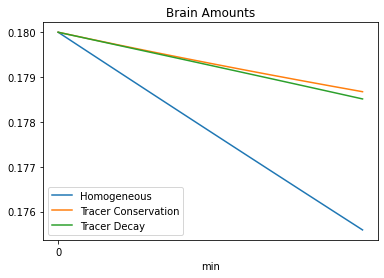

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


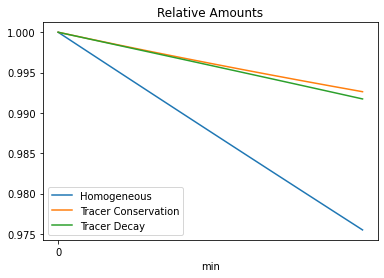

In [9]:
plt.figure()
# Plot amounts for all models
for model, info in CASES.items():
    t = values[model]["time"]
    amounts = values[model]["amounts_total"]
    plt.plot(t, amounts, label=info['label'])

plt.xticks(t[::60], (t[::60]/ 60).astype(int))
plt.xlabel("min")
plt.legend()
plt.title("Brain Amounts")
plt.show()

plt.figure()
# Plot relative amounts for all models
for model, info in CASES.items():
    t = values[model]["time"]
    amounts = values[model]["amounts_total"]
    plt.plot(t, amounts / amounts[0], label=info['label'])
plt.xticks(t[::60], (t[::60]/ 60).astype(int))
plt.xlabel("min")
plt.legend()
plt.title("Relative Amounts")
plt.savefig("test.eps", bbox_inches="tight")
plt.show()

### Run Simulations
Perform simulation for all models with all resolutions, for a full 24 hours.

In [10]:
resolutions = [8, 16, 32] #, 64]
models = ['homogeneous', 'tracerconservation', 'tracerdecay']
timesteps = [60, 600, 3600]

# dt = 60.
T = 3600. * 6. # 24

print(f"""{40*"="}
Resolutions: \t{resolutions}
Models: \t{models}
dt: \t\t{timesteps}
T: \t\t{T}s i.e. {T/3600:.1f}h
{40*"="}""")


# Uncomment if you want a prompt to assertain correct results.
# Useful to avoid unintentional long-running simulations.
# proceed = input("Are these setting correct? (y/N)")
# print()
# if proceed.lower() != 'y':
#     raise SystemExit("Stop right there!")
    
for res in resolutions:
    for model in models:
        for dt in timesteps:
            tic = pytime.time()
            print(f"== Mesh {res} | Model: {model} | Timestep: {dt} ==")
            # Define problem with storage path
            path = f"{RESULTS_DIR}/results-{model}-mesh{res}-dt{dt}"
            meshfile = f"{MESH_DIR}/mesh{res}.h5"
            problem = ratbrain_diffusion(meshfile, path, model, dt, T)
            toc = pytime.time()
            elapsed = toc - tic
            print()
            print(f"Solved in {int( elapsed / 60):2d}min {int(elapsed %60):2d}s")
            print()        

Resolutions: 	[8, 16, 32]
Models: 	['homogeneous', 'tracerconservation', 'tracerdecay']
dt: 		[60, 600, 3600]
T: 		21600.0s i.e. 6.0h
== Mesh 8 | Model: homogeneous ==
[====================]   60.0min / 60.0 min

Solved in  0min  7s

== Mesh 8 | Model: homogeneous | Timestep: 600 ==
[====================]  360.0min / 360.0min

Solved in  0min  2s

== Mesh 8 | Model: homogeneous | Timestep: 3600 ==
[====================]  360.0min / 360.0min

Solved in  0min  0s

== Mesh 8 | Model: tracerconservation | Timestep: 60 ==
[====================]  360.0min / 360.0min

Solved in  0min  8s

== Mesh 8 | Model: tracerconservation | Timestep: 600 ==
[====================]  360.0min / 360.0min

Solved in  0min  0s

== Mesh 8 | Model: tracerconservation | Timestep: 3600 ==
[====================]  360.0min / 360.0min

Solved in  0min  0s

== Mesh 8 | Model: tracerdecay | Timestep: 60 ==
[====================]  360.0min / 360.0min

Solved in  0min  7s

== Mesh 8 | Model: tracerdecay | Timestep: 600 ==